## Continuous case (Ambiguity Calculation)

For continuous case ambiguty calculation we are calculating the overlap region beteween the hypercube of feature space of different classes.

$\LARGE Formula:   mean(\frac{A_{inter1}}{A_{class1}}, \frac{A_{inter2}}{A_{class2}}....) $.

$A_{inter1}$ is the number of samples of class 1 in the common region and $A_{class1}$ is the number of total samples that belongs to class 1.


    feature1   feature2  class
0  35.740023  93.669750    0.0
1  49.013754  99.665744    0.0
2  34.017488  98.319512    0.0
3  34.061822  92.283300    0.0
4  39.225161  83.617416    0.0


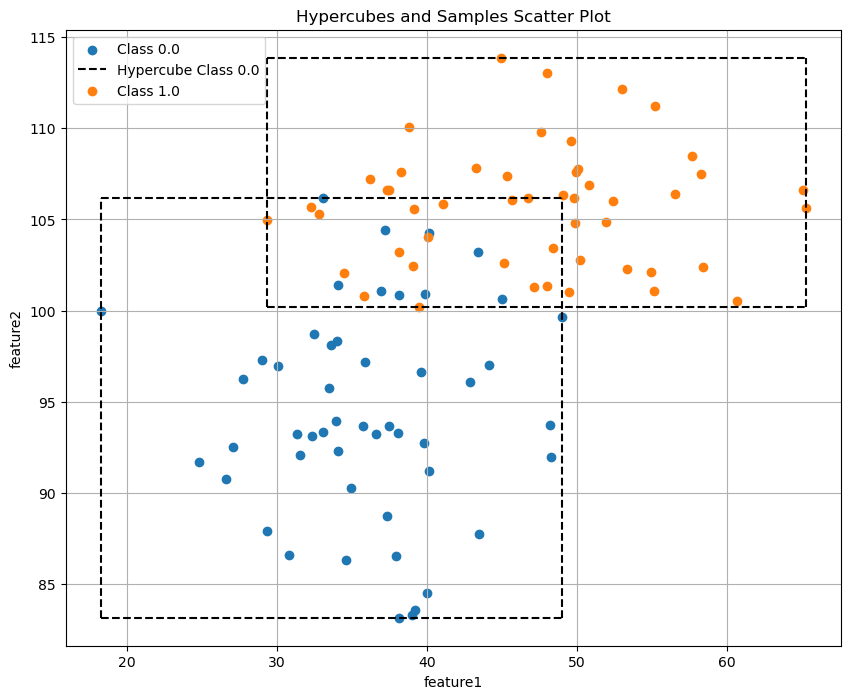

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to generate dataset
def create_synthetic_dataset(num_samples, num_classes, num_features=2, overlap=0.5, random_state=None):

    if random_state is not None:
        np.random.seed(random_state)
    
    samples_per_class = num_samples // num_classes
    data = []
    class_labels = []
    
    # Initial means for the first class
    base_means = np.random.rand(num_features) * 100
    
    for cls in range(num_classes):
        # Adjust means for the current class to control overlap
        means = base_means + cls * (1 - overlap) * 20  # Adjusting overlap level
        std_devs = np.random.rand(num_features) * 10
        
        # Generate samples for this class
        class_data = np.random.randn(samples_per_class, num_features) * std_devs + means
        data.append(class_data)
        class_labels += [cls] * samples_per_class
    
    # Combine data from all classes
    data = np.vstack(data)
    class_labels = np.array(class_labels)
    
    # Create DataFrame
    columns = [f'feature{i+1}' for i in range(num_features)] + ['class']
    df = pd.DataFrame(np.column_stack((data, class_labels)), columns=columns)
    
    return df

# Functions to plot hypercube with scatter plots
def plot_hypercube_and_samples(df, feature_x, feature_y, class_column):
    classes = df[class_column].unique()
    plt.figure(figsize=(10, 8))
    
    for cls in classes:
        subset = df[df[class_column] == cls]
        min_x, max_x = subset[feature_x].min(), subset[feature_x].max()
        min_y, max_y = subset[feature_y].min(), subset[feature_y].max()
        
        # Plotting samples
        plt.scatter(subset[feature_x], subset[feature_y], label=f'Class {cls}')
        
        # Plotting hypercube boundaries
        plt.plot([min_x, max_x], [min_y, min_y], 'k--', label=f'Hypercube Class {cls}' if cls == classes[0] else "")
        plt.plot([min_x, max_x], [max_y, max_y], 'k--')
        plt.plot([min_x, min_x], [min_y, max_y], 'k--')
        plt.plot([max_x, max_x], [min_y, max_y], 'k--')
    
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title('Hypercubes and Samples Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.show()


synthetic_data = create_synthetic_dataset(num_samples=100, num_classes=2, num_features=2, random_state=42)
print(synthetic_data.head())

plot_hypercube_and_samples(synthetic_data, 'feature1', 'feature2', 'class')


# Function for hypercube visualization


In [52]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

def calculate_continuous_case_ambiguity(df, class_column):
    features = df.columns.drop(class_column)
    classes = df[class_column].unique()

    # Step 1: Calculate Hypercubes
    grouped = df.groupby(class_column)[features]
    min_values = grouped.min()
    max_values = grouped.max()
    hypercubes = {cls: (min_values.loc[cls].values, max_values.loc[cls].values) for cls in classes}

    # Step 2: Calculate Overlap Regions
    overlap_regions = []
    class_list = list(hypercubes.keys())
    num_classes = len(class_list)
    
    for i in range(num_classes):
        for j in range(i + 1, num_classes):
            min_overlap = np.maximum(hypercubes[class_list[i]][0], hypercubes[class_list[j]][0])
            max_overlap = np.minimum(hypercubes[class_list[i]][1], hypercubes[class_list[j]][1])
            if np.all(min_overlap <= max_overlap):
                overlap_regions.append((class_list[i], class_list[j], min_overlap, max_overlap))

    # Step 3: Count Samples in Overlap Regions
    samples = df[features].values
    class_labels = df[class_column].values

    samples_in_overlap = {}

    for cls1, cls2, min_overlap, max_overlap in overlap_regions:
        in_overlap_cls1 = np.all((samples >= min_overlap) & (samples <= max_overlap), axis=1) & (class_labels == cls1)
        in_overlap_cls2 = np.all((samples >= min_overlap) & (samples <= max_overlap), axis=1) & (class_labels == cls2)

        count_cls1 = np.sum(in_overlap_cls1)
        count_cls2 = np.sum(in_overlap_cls2)

        region_key = f'{cls1}-{cls2}'
        samples_in_overlap[region_key] = {cls1: count_cls1, cls2: count_cls2}

    # Step 4: Calculate Ambiguity
    total_samples_per_class = df[class_column].value_counts().to_dict()
    print("total samples per class:")
    print(total_samples_per_class)
    ambiguity_values = {cls: 0 for cls in classes}

    for region, counts in samples_in_overlap.items():
        cls1, cls2 = region.split('-')
        cls1 = float(cls1)  # Ensure class labels are correctly interpreted
        cls2 = float(cls2)
        if cls1 in total_samples_per_class and cls2 in total_samples_per_class:
            if total_samples_per_class[cls1] > 0:
                ambiguity_values[cls1] += counts[cls1] / total_samples_per_class[cls1]
            if total_samples_per_class[cls2] > 0:
                ambiguity_values[cls2] += counts[cls2] / total_samples_per_class[cls2]

    mean_ambiguity = np.mean(list(ambiguity_values.values())) if ambiguity_values else 0.0

    return mean_ambiguity, overlap_regions, samples_in_overlap


# Example usage
data3 = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'feature2': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'class': [1, 1, 2, 1, 2, 2, 2, 3, 2, 3, 3]
})

data2 = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'class': [1, 1, 2, 1, 2, 2, 2, 3, 2, 3, 3]
})

data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6],
    'feature2': [5, 6, 7, 8, 9, 10],
    'class': [0, 0, 1, 1, 0, 1]
})
ambiguity, overlap_regions, samples_in_overlap = calculate_continuous_case_ambiguity(synthetic_data, 'class')

print(f'Continuous Case Ambiguity: {ambiguity}')
print("Overlap regions between classes:")
for cls1, cls2, min_overlap, max_overlap in overlap_regions:
    print(f"Classes {cls1} and {cls2}: Min overlap {min_overlap}, Max overlap {max_overlap}")

print("Samples in Overlap Regions:")
for region, counts in samples_in_overlap.items():
    print(f"Overlap region {region}: {counts}")


total samples per class:
{0.0: 50, 1.0: 50}
Continuous Case Ambiguity: 0.25
Overlap regions between classes:
Classes 0.0 and 1.0: Min overlap [ 29.3617319 100.1754   ], Max overlap [ 49.01375402 106.16025114]
Samples in Overlap Regions:
Overlap region 0.0-1.0: {0.0: 9, 1.0: 16}


<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
C:\Users\shibl\AppData\Local\Temp\ipykernel_13148\933680978.py:2: SyntaxWarning: invalid escape sequence '\F'
  df = pd.read_csv("D:\FAU_Courses\FAU Summer 2024\Seminar\Codes\data\kidney-stone-dataset.csv")


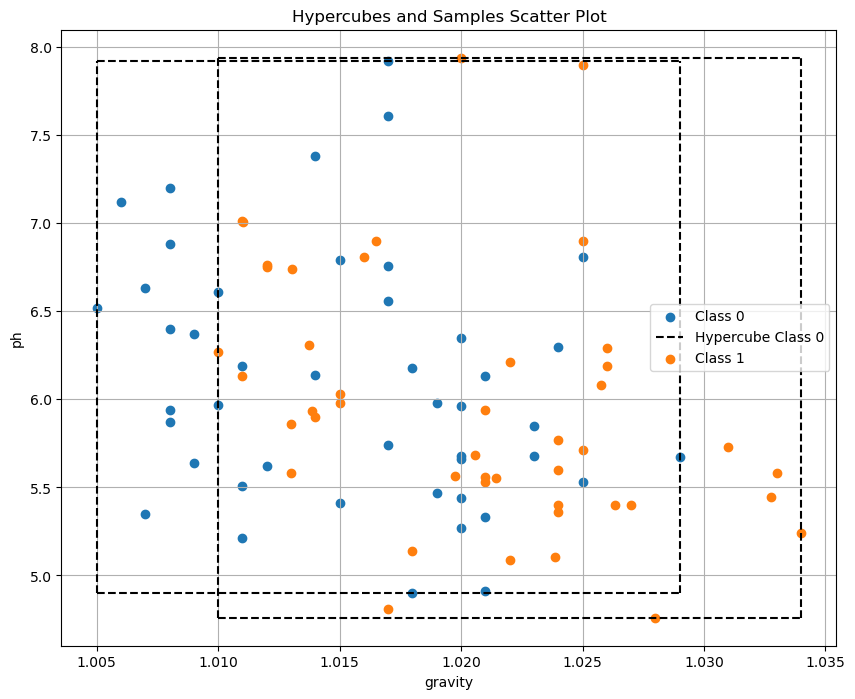

In [53]:
# implementation on real world datasets
df = pd.read_csv("D:\FAU_Courses\FAU Summer 2024\Seminar\Codes\data\kidney-stone-dataset.csv")


plot_hypercube_and_samples(df, 'gravity', 'ph', 'target')

df_dropped = df.drop("Unnamed: 0", axis=1)

In [54]:
df_dropped.head()

ambiguity, overlap_regions, samples_in_overlap = calculate_continuous_case_ambiguity(df_dropped, 'target')

print(f'Continuous Case Ambiguity: {ambiguity}')
print("Overlap regions between classes:")
for cls1, cls2, min_overlap, max_overlap in overlap_regions:
    print(f"Classes {cls1} and {cls2}: Min overlap {min_overlap}, Max overlap {max_overlap}")

print("Samples in Overlap Regions:")
for region, counts in samples_in_overlap.items():
    print(f"Overlap region {region}: {counts}")

total samples per class:
{0: 45, 1: 45}
Continuous Case Ambiguity: 0.6777777777777778
Overlap regions between classes:
Classes 0 and 1: Min overlap [  1.01   4.9  251.     5.1   64.     0.27], Max overlap [1.029e+00 7.920e+00 1.107e+03 3.360e+01 5.500e+02 8.480e+00]
Samples in Overlap Regions:
Overlap region 0-1: {0: 29, 1: 32}


In [55]:
# Implementaing classical machine learning algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
def select_model(model):
    if model == "logistic_regression" :
        return LogisticRegression() 
    elif model == "naive_bayes":
        return GaussianNB()
    elif model == "random_forest":
        return RandomForestClassifier(max_depth=2, random_state=0)
    else:
        raise ValueError("Unknown model type: {}".format(model))
    


In [56]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

X = df_dropped.drop("target", axis=1)
y = df_dropped['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_names = ["logistic_regression", "naive_bayes", "random_forest"]

for model_name in model_names:
    model = select_model(model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # global performance
    global_accuracy = accuracy_score(y_test, y_pred)
    # Cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(f"Model name: {model_name}, global_accuracy: {global_accuracy}, Scores for each fold: {scores}, Average_score: {np.mean(scores)}")

Model name: logistic_regression, global_accuracy: 0.6666666666666666, Scores for each fold: [0.66666667 0.66666667 0.77777778 0.72222222 0.66666667], Average_score: 0.7
Model name: naive_bayes, global_accuracy: 0.6111111111111112, Scores for each fold: [0.61111111 0.77777778 0.77777778 0.61111111 0.55555556], Average_score: 0.6666666666666666
Model name: random_forest, global_accuracy: 0.6666666666666666, Scores for each fold: [0.66666667 0.83333333 0.83333333 0.77777778 0.66666667], Average_score: 0.7555555555555555


In [61]:
X.columns.to_list()

['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

## Continuous case (Error calculation):


$\LARGE Formula: \int_{R_1} P(C_2) + \int_{R_2} P(C_1)$


In [70]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree
from scipy import stats

def calculate_error_probability(df, feature_columns, label_column):
    # Train the decision tree
    X = df[feature_columns]
    y = df[label_column]

    clf = DecisionTreeClassifier(max_depth=None)
    clf.fit(X, y)

    training_accuracy = clf.score(X, y)
    print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

    # Function to extract rectangles and labels from a trained decision tree
    def get_rectangles_from_tree(tree):
        left = tree.children_left
        right = tree.children_right
        threshold = tree.threshold
        feature = tree.feature
        value = tree.value
        
        def recurse(node, bounds):
            if feature[node] == _tree.TREE_UNDEFINED:
                # It's a leaf node
                leaf_label = np.argmax(value[node][0])
                return [(bounds, leaf_label)]
            
            new_bounds_left = [list(b) for b in bounds]
            new_bounds_right = [list(b) for b in bounds]
            
            feature_index = feature[node]
            threshold_value = threshold[node]
            
            new_bounds_left[feature_index][1] = threshold_value
            new_bounds_right[feature_index][0] = threshold_value
            
            left_rectangles = recurse(left[node], new_bounds_left)
            right_rectangles = recurse(right[node], new_bounds_right)
            
            return left_rectangles + right_rectangles

        # Initialize bounds for each feature
        initial_bounds = [[-np.inf, np.inf] for _ in range(tree.n_features)]
        rectangles = recurse(0, initial_bounds)
        return rectangles

    # Extract rectangles and labels from the decision tree
    rectangles = get_rectangles_from_tree(clf.tree_)

    # Calculate KDE for each class
    class_0_data = df[df[label_column] == 0][feature_columns]
    class_1_data = df[df[label_column] == 1][feature_columns]

    kde_class_0 = stats.gaussian_kde(class_0_data.T)
    kde_class_1 = stats.gaussian_kde(class_1_data.T)

    # Calculate probabilities for the segments
    segment_probabilities = []
    for rect, label in rectangles:
        bounds_min = [b[0] for b in rect]
        bounds_max = [b[1] for b in rect]
        segment = df[np.all((df[feature_columns] >= bounds_min) & (df[feature_columns] < bounds_max), axis=1)]
        if not segment.empty:
            actual_value = segment[label_column].iloc[0]
            if actual_value == 0.0:
                segment_probabilities.append(kde_class_1.integrate_box(bounds_min, bounds_max, maxpts=200000))
            else:
                segment_probabilities.append(kde_class_0.integrate_box(bounds_min, bounds_max, maxpts=200000))

    # Compute total error probability
    total_error_probability_all_segments = np.sum(segment_probabilities)
    
    
    
    return total_error_probability_all_segments


feature_columns = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
label_column = 'target'
total_error_probability = calculate_error_probability(df_dropped, feature_columns, label_column)

print(f"Total error probability across all segments: {total_error_probability:.4f}")
print(f"Accuracy: {1 - total_error_probability:.4f}")


Training Accuracy: 100.00%


C:\Users\shibl\AppData\Local\Temp\ipykernel_13148\3060036659.py:67: UserWarning: An integral in _mvn.mvnun requires more points than 6000
  segment_probabilities.append(kde_class_1.integrate_box(bounds_min, bounds_max, maxpts=200000))
C:\Users\shibl\AppData\Local\Temp\ipykernel_13148\3060036659.py:67: UserWarning: An integral in _mvn.mvnun requires more points than 6000
  segment_probabilities.append(kde_class_1.integrate_box(bounds_min, bounds_max, maxpts=200000))
C:\Users\shibl\AppData\Local\Temp\ipykernel_13148\3060036659.py:67: UserWarning: An integral in _mvn.mvnun requires more points than 6000
  segment_probabilities.append(kde_class_1.integrate_box(bounds_min, bounds_max, maxpts=200000))
C:\Users\shibl\AppData\Local\Temp\ipykernel_13148\3060036659.py:69: UserWarning: An integral in _mvn.mvnun requires more points than 6000
  segment_probabilities.append(kde_class_0.integrate_box(bounds_min, bounds_max, maxpts=200000))


Total error probability across all segments: 0.5743
Accuracy: 0.4257


C:\Users\shibl\AppData\Local\Temp\ipykernel_13148\3060036659.py:69: UserWarning: An integral in _mvn.mvnun requires more points than 6000
  segment_probabilities.append(kde_class_0.integrate_box(bounds_min, bounds_max, maxpts=200000))


## Discrete case (Ambiguity calculation):
$\LARGE Formula: \frac{d} {d-1} \sum_N 1 - max(\frac{|i_j|} {|i|}) \frac{1}{N} $

where d = no of class, N = Permutation of Features 